***Machine learning process for German text classification***

- Connection to be made with drive

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pwd        # current working directory

/content


   - Basic libraries import

In [ ]:
!pip install hvplot

In [6]:
import pandas as pd
import numpy as np
import re
import pickle
import sklearn
import holoviews as hv
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import Word
from wordcloud import WordCloud


import hvplot
import nltk
from bokeh.io import output_notebook
output_notebook()

from hvplot import pandas
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

-  Read file:


In [4]:
df = pd.read_csv('/content/drive/MyDrive/GermanNLP/sample_data_for_task1.csv')
df.head()

,text,label
0,zucker fabrik,ft
1,Lebensmittel kommssionierung,ft
2,geländer biegen,mr
3,gebäudeausrüstung technische,ct
4,kürbiskernöl softgels,ft


**Data Cleaning**

  - Explore "label" column using value_counts() returns a Series where the unique values in the original
   Series are the indices, and their frequencies.
  - ***Obervation:***  so there are 6 unique category we have in " label"

In [7]:
print(f"\033[1m label_count1: \033[0m \n {df['label'].value_counts()}")

 label_count1:  
 ft     11226
pkg     9617
ct      5061
mr      5016
ch      3688
cnc     2587
Name: label, dtype: int64


- ***Observation:*** There are null value in label field.

In [19]:
print("Check is null in label:",  df['label'].isnull().values.any())
print("Check is null in text:",  df['text'].isnull().sum())

Check is null in label: True
Check is null in text: 0


-  ***Observation:*** we have 100 null value in label. We will exclude rows with null target values from our dataset as its target variable with null value will not make any sense to model training. However, we will retain these rows separately for future testing purposes.

In [20]:
df['label'].isnull().sum()

100

- removed null

In [21]:
df.dropna(inplace=True)   # droped null
df.isnull().sum()

text     0
label    0
dtype: int64

In [22]:
df.info()     #so 2 coumn and 37195 rows

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37195 entries, 0 to 37294
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    37195 non-null  object
 1   label   37195 non-null  object
dtypes: object(2)
memory usage: 871.8+ KB


-  Lets deal with text column: Is there any space or whitespace ?


In [23]:
print("Count of space in Label;",df['label'].str.isspace().sum() )
print("Count of space in Text:",  df['text'].str.isspace().sum() )

Count of space in Label; 0
Count of space in Text: 300


- ***Observation:*** There are 300 instances of whitespace in the text column.

- lets use strip method to remove leading and trailing whitespace (including newline characters) from string values in a DataFrame.This is useful for cleaning up data, especially when dealing with text data where extra whitespace may be present.

In [24]:
df2 = df[['text','label']].apply(lambda x: x.str.strip()).replace('', np.nan)

-  so there now we dont have any space in our label or text column
-  ***Observation***: Info states we have 2 column and non-null counts between the 'text' column (36895 non-null values) and the 'label' column (37195 non-null values), suggests that there are missing values.
- so lets remove it.

In [28]:
print( df2['label'].str.isspace().sum() )
print(  df2['text'].str.isspace().sum() )
print( df2.info())

0
0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 37195 entries, 0 to 37294
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    36895 non-null  object
 1   label   37195 non-null  object
dtypes: object(2)
memory usage: 871.8+ KB
None


- Now we have both text and label with 36895

In [29]:
df2.dropna(inplace=True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36895 entries, 0 to 37294
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    36895 non-null  object
 1   label   36895 non-null  object
dtypes: object(2)
memory usage: 864.7+ KB


- As "text" should contain textual information so lets check if we have any numerical value in the field???

- We are utilizing regular expressions to achieve this task. Any numerical values encountered will be substituted with "blank" in a new column named "cleaned."

In [30]:
df2['cleaned']=df2['text'].apply(lambda x: re.sub('\w*\d\w*','', x))

In [31]:
df2.head()

,text,label,cleaned
0,zucker fabrik,ft,zucker fabrik
1,Lebensmittel kommssionierung,ft,Lebensmittel kommssionierung
2,geländer biegen,mr,geländer biegen
3,gebäudeausrüstung technische,ct,gebäudeausrüstung technische
4,kürbiskernöl softgels,ft,kürbiskernöl softgels


In [32]:
df3=df2

- ***observation***: 301 blank in "cleaned" column which says we had 301 numerical value in our " text" column.
- As blank or numerical value will not make any sense to model, hence remove it.

In [35]:
df3= df3.replace(r'^\s*$', np.nan, regex=True)
df3.isna().sum()

text         0
label        0
cleaned    301
dtype: int64

- now we have 3 column and all with 36594 entries with non-null value in each.

In [36]:
df3.dropna(inplace = True)
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36594 entries, 0 to 37294
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     36594 non-null  object
 1   label    36594 non-null  object
 2   cleaned  36594 non-null  object
dtypes: object(3)
memory usage: 1.1+ MB


In [37]:
df3.head()

,text,label,cleaned
0,zucker fabrik,ft,zucker fabrik
1,Lebensmittel kommssionierung,ft,Lebensmittel kommssionierung
2,geländer biegen,mr,geländer biegen
3,gebäudeausrüstung technische,ct,gebäudeausrüstung technische
4,kürbiskernöl softgels,ft,kürbiskernöl softgels


# **Text** **preprocessing**
* Removing punctuations like . , ! $( ) * % @
* Removing URLs
* Removing Stop words
* Lower casing
* Tokenization
* Stemming
* Lemmatization

In [38]:
stemmer = SnowballStemmer("german")
stop_words = set(stopwords.words("german"))


def clean_text(text, for_embedding=False):
    """
        - remove any html tags (< /br> often found)
        - Keep only ASCII + European Chars and whitespace, no digits
        - remove single letter chars
        - convert all whitespaces (tabs etc.) to single wspace
        if not for embedding (but e.g. tdf-idf):
        - all lowercase
        - remove stopwords, punctuation and stemm
    """
    RE_WSPACE = re.compile(r"\s+", re.IGNORECASE)
    RE_TAGS = re.compile(r"<[^>]+>")
    RE_ASCII = re.compile(r"[^A-Za-zÀ-ž ]", re.IGNORECASE)
    RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž]\b", re.IGNORECASE)
    if for_embedding:
        # Keep punctuation
        RE_ASCII = re.compile(r"[^A-Za-zÀ-ž,.!? ]", re.IGNORECASE)
        RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž,.!?]\b", re.IGNORECASE)

    text = re.sub(RE_TAGS, " ", text)
    text = re.sub(RE_ASCII, " ", text)
    text = re.sub(RE_SINGLECHAR, " ", text)
    text = re.sub(RE_WSPACE, " ", text)

    word_tokens = word_tokenize(text)
    words_tokens_lower = [word.lower() for word in word_tokens]

    if for_embedding:
        # no stemming, lowering and punctuation / stop words removal
        words_filtered = word_tokens
    else:
        words_filtered = [
            stemmer.stem(word) for word in words_tokens_lower if word not in stop_words
        ]

    text_clean = " ".join(words_filtered)
    return text_clean

In [39]:
%%time
# Clean Comments
df3["text_clean"] = df3.loc[df3["cleaned"].str.len() > 20, "cleaned"]
df3["text_clean"] = df3["cleaned"].map(
    lambda x: clean_text(x, for_embedding=False) if isinstance(x, str) else x)

CPU times: user 3.21 s, sys: 24.1 ms, total: 3.24 s
Wall time: 3.3 s


- ***Obervation***: Each of the text preprocessing steps outlined is executed on the "cleaned" column, and the outcome is saved in a new column named "text_clean."
- It resultant properly as we can see all words in text_clean are in lower case, and words are stemmed (refer row42 & row45). And interestingly see row44 with different language is marked as blank in text_clean column.
- This also means now we have empty cells in "text_clean" column which has to be dealt properly as it will used while modelling.

In [40]:
df3.iloc[40:].head()

,text,label,cleaned,text_clean
41,Dach anheben,ct,Dach anheben,dach anheb
42,Laserzuschnitte Holz,mr,Laserzuschnitte Holz,laserzuschnitt holz
43,Dinkel kleie,ft,Dinkel kleie,dinkel kleie
44,吉祥,mr,吉祥,
45,betonschneiden kernbohrer,mr,betonschneiden kernbohrer,betonschneid kernbohr


- 433 null in text_clean column

In [41]:
df4= df3.replace(r'^\s*$', np.nan, regex=True)
df4.isna().sum()

text            0
label           0
cleaned         0
text_clean    433
dtype: int64

- now 4 column and 36161 non-null value

In [42]:
df4.dropna(inplace = True)
df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36161 entries, 0 to 37294
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        36161 non-null  object
 1   label       36161 non-null  object
 2   cleaned     36161 non-null  object
 3   text_clean  36161 non-null  object
dtypes: object(4)
memory usage: 1.4+ MB


-- *previous row44 is not present anymore*

In [43]:
df4.iloc[40:].head()

,text,label,cleaned,text_clean
41,Dach anheben,ct,Dach anheben,dach anheb
42,Laserzuschnitte Holz,mr,Laserzuschnitte Holz,laserzuschnitt holz
43,Dinkel kleie,ft,Dinkel kleie,dinkel kleie
45,betonschneiden kernbohrer,mr,betonschneiden kernbohrer,betonschneid kernbohr
46,emaillierte behälter,pkg,emaillierte behälter,emailliert behalt


# **Data Visualization**

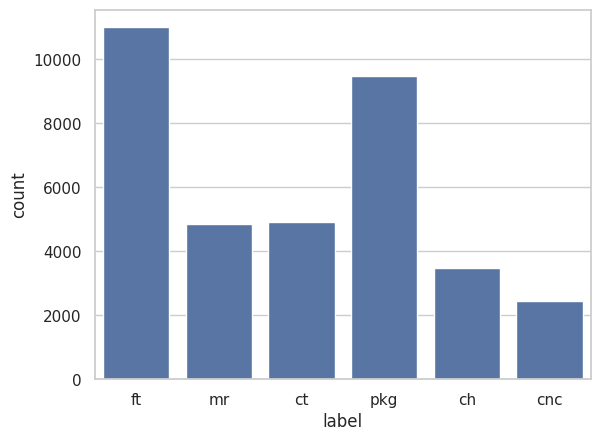

In [45]:
sns.set_theme(style="whitegrid")
sns.countplot(x=df4["label"])
plt.show()

- word cloud is a visualization technique used to represent text data, where the size of each word indicates its frequency or importance within the text. In a word cloud plot, the most frequent or important words are displayed prominently, while less frequent words appear smaller or less prominent.

- Here i am visualizing 3 label class using word cloud i.e "ft", "cnc", "pkg"

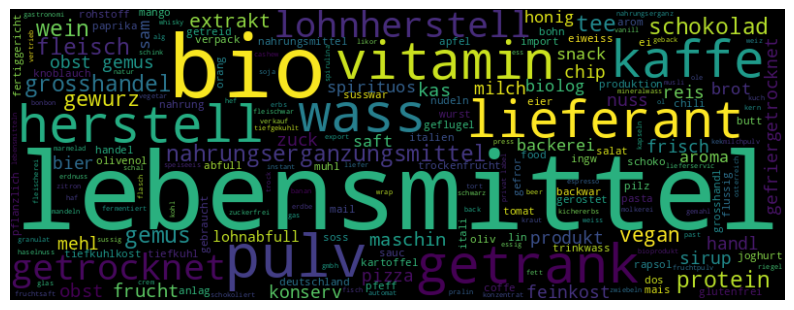

In [47]:
from textblob import Word
from wordcloud import WordCloud

normal_words =' '.join([text for text in df4['text_clean'][df4['label'] == 'ft']])
wordcloud = WordCloud(width=800, height=300, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

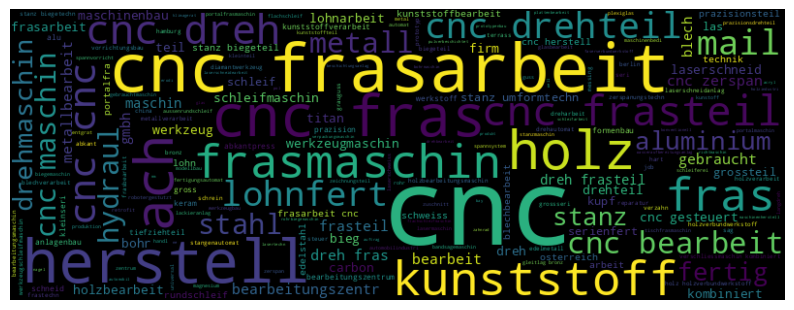

In [48]:
normal_words =' '.join([text for text in df4['text_clean'][df4['label'] == 'cnc']])
wordcloud = WordCloud(width=800, height=300, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

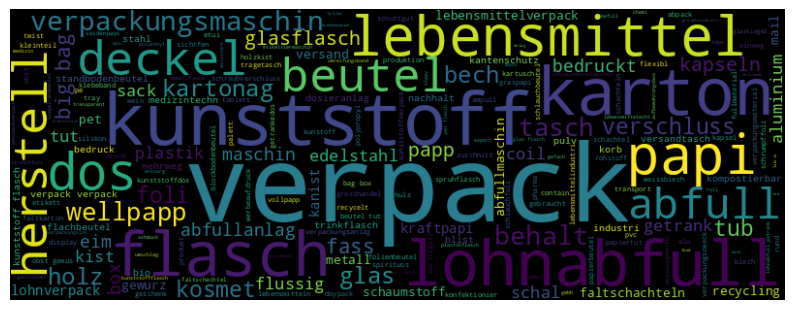

In [49]:
normal_words =' '.join([text for text in df4['text_clean'][df4['label'] == 'pkg']])
wordcloud = WordCloud(width=800, height=300, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

-  *Word frequency of most common words in text*

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
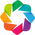

:Bars   [index]   (Word frequency of most common words in text)

In [52]:
from bokeh.models import NumeralTickFormatter
import pandas as pd
import hvplot
from hvplot import pandas
import hvplot.pandas  # Importing hvplot
import holoviews as hv
hv.extension('bokeh')

# Word Frequency of most common words
word_freq = pd.Series(" ".join(df4["text_clean"]).split()).value_counts()
word_freq[1:40].rename("Word frequency of most common words in text").hvplot.bar(
    rot=45
).opts(width=700, height=400, yformatter=NumeralTickFormatter(format="0,0"))


- creating new dataframe df5 with only two column that is required for our model training.

In [79]:
df5=df4[['text_clean','label']]
df5.head()

,text_clean,label
0,zuck fabrik,ft
1,lebensmittel kommssionier,ft
2,geland bieg,mr
3,gebaudeausrust technisch,ct
4,kurbiskernol softgel,ft


In [57]:
# Define mapping dictionary
mapping = {'ft': 0, 'mr': 1, 'ct': 2, 'pkg':3, 'ch':4, 'cnc':5}

# Map values using the dictionary
df5['label2'] = df5['label'].map(mapping)
df5['label2'].dtype

<ipython-input-57-78f40e7c1221>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5['label2'] = df5['label'].map(mapping)


dtype('int64')

In [ ]:
df5.drop(columns=['label'], inplace=True)


In [80]:
df5.head()

,text_clean,label
0,zuck fabrik,ft
1,lebensmittel kommssionier,ft
2,geland bieg,mr
3,gebaudeausrust technisch,ct
4,kurbiskernol softgel,ft


- **TFID vectorization**

In [81]:
"""
Compute unique word vector with frequencies
exclude very uncommon (<10 obsv.) and common (>=30%) words
use pairs of two words (ngram)
So, ngram_range=(1, 2) indicates that you want to consider both unigrams (individual words) and
bigrams (sequences of two words) when analyzing the text data.
"""
vectorizer = TfidfVectorizer(
    analyzer="word", max_df=0.3, min_df=10, ngram_range=(1, 2), norm="l2"
)
vectorizer.fit(df5["text_clean"])


TfidfVectorizer(max_df=0.3, min_df=10, ngram_range=(1, 2))

In [82]:
# Vector representation of vocabulary
word_vector = pd.Series(vectorizer.vocabulary_).sample(5, random_state=1)
print(f"Unique word (ngram) vector extract:\n\n {word_vector}")

Unique word (ngram) vector extract:

 las           676
cnc fertig    194
acryl          18
curry         220
frasarbeit    376
dtype: int64


# **Modelling**

-  Train and test data have split of 75 and 25 size respectively

In [83]:
# Sample data - 25% of data to test set
train, test = train_test_split(df5, random_state=1, test_size=0.25, shuffle=True)

X_train = train["text_clean"]
Y_train = train["label"]
X_test = test["text_clean"]
Y_test = test["label"]
print(X_train.shape)
print(X_test.shape)

(27120,)
(9041,)


In [84]:
# transform each sentence to numeric vector with tf-idf value as elements
X_train_vec = vectorizer.transform(X_train)
X_test_vec = vectorizer.transform(X_test)
X_train_vec.get_shape()

(27120, 1311)

In [85]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, f1_score, recall_score

**Logistic Regression**

In [86]:
modellr = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)

# Fit the model to the training data
modellr.fit(X_train_vec, Y_train)

# Predict on the testing data
y_pred = modellr.predict(X_test_vec)

# Evaluate the model
print("Accuracy: "+str(accuracy_score(Y_test,y_pred)))
print(classification_report(Y_test, y_pred))


Accuracy: 0.8452604800353943
              precision    recall  f1-score   support

          ch       0.93      0.78      0.85       863
         cnc       0.86      0.73      0.79       605
          ct       0.94      0.84      0.89      1219
          ft       0.78      0.94      0.85      2767
          mr       0.82      0.78      0.80      1204
         pkg       0.88      0.82      0.85      2383

    accuracy                           0.85      9041
   macro avg       0.87      0.82      0.84      9041
weighted avg       0.85      0.85      0.85      9041



- Predict some text input  on Logistic regression

In [92]:
mc = vectorizer.transform(["getrank automatenservic","automotiv chip", "hydraul lohnfert","holz laserzuschnitt"])
#m = transformer.transform(mc)
y_pred = modellr.predict(mc)
print(y_pred)


['ft' 'ft' 'cnc' 'mr']


**Support Vector Machine**

In [88]:
modelsvm = LinearSVC()

# Fit the model to the training data
modelsvm.fit(X_train_vec, Y_train)

# Predict on the testing data
y_pred = modelsvm.predict(X_test_vec)

# Evaluate the model
print("Accuracy: "+str(accuracy_score(Y_test,y_pred)))
print(classification_report(Y_test, y_pred))


Accuracy: 0.843601371529698
              precision    recall  f1-score   support

          ch       0.92      0.78      0.84       863
         cnc       0.85      0.73      0.79       605
          ct       0.94      0.85      0.89      1219
          ft       0.78      0.93      0.85      2767
          mr       0.81      0.78      0.80      1204
         pkg       0.88      0.82      0.85      2383

    accuracy                           0.84      9041
   macro avg       0.86      0.82      0.84      9041
weighted avg       0.85      0.84      0.84      9041



- Predict some text input on SVM

In [94]:
mc = vectorizer.transform(["getrank automatenservic","automotiv chip", "hydraul lohnfert","gesellschaft verpack konfektionier"])
#m = transformer.transform(mc)
y_pred = modelsvm.predict(mc)
print(y_pred)


['ft' 'ft' 'cnc' 'pkg']


- **Observation**: We'll adhere to using the Logistic Regression model since the accuracy between the two models doesn't vary significantly. However, it's worth noting that the F1-score favors Logistic Regression over SVM.

- Download "pkl" file

In [97]:
# Specify the directory path where you want to save the pickled model
directory_path = '/content/drive/MyDrive/GermanNLP/'

# Specify the file name for the pickled model
pkl_filename = "modellr.pkl"

# Concatenate the directory path and file name
file_path = directory_path + pkl_filename

# Save the pickled model to the specified file path
with open(file_path, 'wb') as file:
    pickle.dump(modellr, file)

- Fast API

In [134]:
from pydantic import BaseModel

class Text(BaseModel):
    text_clean: str

    class Config:
        schema_extra = {
            "example": {
                "text_clean": "gesellschaft verpack konfektionier"
            }
        }

In [ ]:
from fastapi import FastAPI
import pickle

app = FastAPI()

@app.on_event("startup")
def load_model():
    global model
    model = pickle.load(open("modellr.pkl", "rb"))

@app.get('/')
def index():
    return {'message': 'This is to predict German text classification'}


@app.post('/predict')
def get_text_category(data: Text):
    received = data.dict()
    text_clean = received['text_clean']

    pred_name = model.predict([text_clean]).tolist()[0]
    return {'prediction': pred_name}

In [ ]:
from google.colab.output import eval_js
server= print(eval_js("google.colab.kernel.proxyPort(8090)"))

# **Future Work Suggestions:**

If i had a more week, following thing i would have done based on my currect observation on this data.

1.   Treat well with imbalance data using Oversampling (SMOTE)
2.   Tried deeplearning model: "LSTM" as its ability to capture long-term dependencies and handle sequential data, LSTM models offer improved accuracy in classifying text.

***Work in Progress***  🙏